In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import pandas as pd
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression

from pyproj import Geod
import cartopy
import cartopy.crs as ccrs

import geoviews as gv
import geoviews.feature as gf
import holoviews as hv
import panel as pn

gv.extension('matplotlib') # Uses MatplotLib backend
gv.output(size=250) # Sets default size for geoview figs
gv.opts.defaults(gv.opts.Layout(sublabel_format="")) # gets rid of subplot lettering for matplotlib combined plots

%matplotlib inline


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

## Initial Data Wrangling 🐴 ##

In [3]:
# ICE-6G_D Model goes back 122 Ka
ICE6G_D_122Ka = xr.open_dataset('~/VS Code/Zhong Geophysics/ICE_MODELS/ICE6G_122Ka/IceT.I6F_C.131QB_VM5a_1deg.nc')
# ICE-6G_C Model (Updated) Goes back 26 Ka
ICE6G_C_26Ka = xr.open_dataset('~/VS Code/Zhong Geophysics/ICE_MODELS/ICE6G_C_Combined/COMBINED_TIME_ICE-6G_C.nc')

In [7]:
ICE6G_D_122Ka.load()
print()

In [8]:
ICE6G_C_26Ka.load()
print()

### Constants

In [9]:
# Approximate m SL/10^6 km^3 ice (meters of sea level rise per 10^6 cubic km of ice)
# From https://linkinghub.elsevier.com/retrieve/pii/S0277379118304074 (sourced from multiple estimates)
mSLRise = [2.485, 2.580, 2.519, 2.478, 2.577, 2.488, 2.466] # m/10^6 km^3

# Volumetric Mean Radius of Earth
R_E = 6371 #km

# Geoid Geometry, using WGS84 Coordinate System (CHECK??)
geod = Geod(ellps="WGS84")


### Methods

In [10]:
 def calc_IceVolume(ice_DS, time_bp):
    """ Estimate Total Volume of ice at a particular time before present.

    Args:
        year (float): thousands of years before present (e.g. input of 26.0 -> 26,000 years before present)
        ice_DS (Dataset): Dataset containing time evolution of ice on Earth
    """
    ice_atyear = ice_DS.sel(Time=time_bp, method="nearest")
    
    total_Volume = 0
    
    ## Need to Find Area of Each Lat/Lon Grid Space
    for lat in ice_atyear["Lat"].values:
        for lon in ice_atyear["Lon"].values:
            # Adjust for lat and lon centering at each 1x1 degree square (e.g. -45.5, 65.5 -> square
            # defined by Lon from -45 to -46 degrees and Lat from 65 to 66 degrees, convert to radians
            lat1 = (lat - 0.5)*np.pi/180 
            lat2 = (lat + 0.5)*np.pi/180
            lon1 = (lon - 0.5)*np.pi/180
            lon2 = (lon + 0.5)*np.pi/180
            
            # Calculate Area of Each square using Archimedes Principle: https://www.pmel.noaa.gov/maillists/tmap/ferret_users/fu_2004/msg00023.html
            area = (R_E**2)*abs(np.sin(lat1)-np.sin(lat2))*abs(lon1-lon2)
            
            # Find Volume using thickness of ice at this position (stgit in meters) and area
            volume = abs(area)*(ice_atyear.stgit.sel(Lon=lon, Lat=lat).values)/1000 # km^3
            total_Volume += volume
    
    return((total_Volume))

present_day_vol = calc_IceVolume(ICE6G_D_122Ka, 0.0)

In [17]:
''' CHECK LGM Timing ~26.0 ka
for i in range(20,30):
    print(f"Time: {i} ka -> {round(calc_IceVolume(ICE6G_D_122Ka, i)-present_day_vol,-6)} km^3")

## Expected ~52*10^6 km^3 (Lambeck 2014, https://doi.org/10.1073/pnas.1411762111)
'''

Time: 20 ka -> 45000000.0 km^3
Time: 21 ka -> 46000000.0 km^3
Time: 22 ka -> 46000000.0 km^3
Time: 23 ka -> 47000000.0 km^3
Time: 24 ka -> 48000000.0 km^3
Time: 25 ka -> 50000000.0 km^3
Time: 26 ka -> 51000000.0 km^3
Time: 27 ka -> 48000000.0 km^3
Time: 28 ka -> 42000000.0 km^3
Time: 29 ka -> 37000000.0 km^3


## Comparision: Original + Modifications = Proposed

### Plotting Comparison Methods

In [12]:
def plot_ice_dist(model, time):
    ice_test = model.stgit # thickness variable

    fig = plt.subplots(figsize=(9,6))

    ax = plt.axes(projection = ccrs.Mercator())
    ax.coastlines()
    ax.gridlines()
    
    
    plot_elem = ice_test.sel(Time = time, method = "nearest").plot(x = 'Lon', y = 'Lat', transform = ccrs.PlateCarree(), cmap="RdBu_r", cbar_kwargs={'shrink':0.4}, ax = ax)
    

In [13]:
def plot_ice_comparison(model_orig, model_new, time, new_label='Proposed'):
    """Plot the three datasets side by side allowing us to see the original distribution, changes we made, and the final map

    Args:
        model_orig (DataArray): Original Distribution of Ice
        model_new (DataArray): New modified distribution of ice
        time (float): number of thousands of years ago that we would like to access (e.g. Input:26.0 -> 26,000 years ago)
        proposed_label (string): identifier for proposed model
    """
    model_difference = (model_new - model_orig)*20
    
    model_triple = xr.concat([model_orig, model_difference, model_new], pd.Index(['Original', 'Difference (scaled by 10)', new_label],name='Version'))

    
    plot_elem = model_triple.stgit.sel(Time = time, method = "nearest").isel(Version = slice(0,3)).plot(x = 'Lon', y = 'Lat',col = 'Version',transform = ccrs.PlateCarree(), cmap="RdBu_r", cbar_kwargs={'shrink':0.4}, subplot_kws={'projection':ccrs.Mercator()}, aspect = 1, size = 7)
    
    for ax in plot_elem.axs.flat:
        ax.coastlines()
        ax.gridlines()
    
    
    return model_triple
        
        
    

In [14]:
def plot_ice_comparison_alt(model_orig, model_new, time, new_label='Proposed'):
    """Plot the three datasets side by side allowing us to see the original distribution, changes we made, and the final map
       Changes from original plot_ice_comparison() -> alt version allows for custom scaling and coloring of each graph and other attributes

    Args:
        model_orig (DataArray): Original Distribution of Ice
        model_new (DataArray): New modified distribution of ice
        time (float): number of thousands of years ago that we would like to access (e.g. Input:26.0 -> 26,000 years ago)
        proposed_label (string): identifier for proposed model
    """
    ## Change in ice thickness between models
    model_diff = model_new - model_orig
    
    ## Convert datasets to geoview datasets
    gv_orig = gv.Dataset(model_orig.copy().sel(Time = 26.0), ['Lon', 'Lat'], 'stgit', crs=ccrs.PlateCarree())
    gv_new = gv.Dataset(model_new.copy().sel(Time = 26.0), ['Lon', 'Lat'], 'stgit', crs=ccrs.PlateCarree())
    gv_diff = gv.Dataset(model_diff.copy().sel(Time = 26.0), ['Lon', 'Lat'], 'stgit', crs=ccrs.PlateCarree())
    
    ## Generate geoview images for each dataset
    image_orig = gv_orig.to(gv.Image)
    image_new = gv_new.to(gv.Image)
    image_diff = gv_diff.to(gv.Image)
    
    ## Calibrate options for each image and plot
    plot_orig = image_orig.opts(projection=ccrs.Mercator(),cmap='RdBu_r', colorbar=True, title = 'Original', xticks=5, yticks = 7)*gf.coastline
    plot_new = image_new.opts(projection=ccrs.Mercator(),cmap='RdBu_r', colorbar=True, title = new_label, xticks=5, yticks = 7)*gf.coastline
    plot_diff = image_diff.opts(projection=ccrs.Mercator(),cmap='Viridis', colorbar=True, clim = (model_diff.stgit.min(), model_diff.stgit.max()), title = 'Difference', xticks=5, yticks = 7)*gf.coastline ## Note: The options for this one suck and are very long, mostly so that the color bar has custom scaling, see clim attr
    
    
    return plot_orig+plot_diff+plot_new
        
        
    

## Different Proposed Models

#### Original Model

In [25]:
time = 26.0 # Ka

print("Original Ice Volume: ", round(calc_IceVolume(ICE6G_D_122Ka,time) - present_day_vol,-6))

Original Ice Volume:  51000000.0


#### Simple Linear Model

In [19]:
# Modification Constants
m_const = 1.01
b_const = 0

Linear_Test = ICE6G_D_122Ka.copy()
Linear_Test['stgit'] = Linear_Test.stgit*m_const + b_const*(Linear_Test.stgit > 200)

print("Simple Linear Ice Volume: ", round(calc_IceVolume(Linear_Test, time) - present_day_vol,-6))

Simple Linear Ice Volume:  52000000.0


#### Latitude-Dependent Linear Model

In [41]:
# Modifying Constants
m_lat_north = 1.04
b_lat_north = 0
m_lat_south = 0.98
b_lat_south = 0

Linear_Lat_Test = ICE6G_D_122Ka.copy()

# Retrieve Ice thickness separately
northern_stgit = Linear_Lat_Test['stgit'].sel(Lat=slice(0, 90)) # Including equator in northern and not southern, shouldn't matter at all though
southern_stgit = Linear_Lat_Test['stgit'].sel(Lat=slice(-90,0))

# Modify with set constants
northern_stgit = northern_stgit*m_lat_north + b_lat_north
southern_stgit = southern_stgit*m_lat_south + b_lat_south

Linear_Lat_Test = xr.merge([northern_stgit, southern_stgit])

print("Latitude-Dependent Linear Ice Volume: ", round(calc_IceVolume(Linear_Lat_Test, time) - present_day_vol,-6))

Latitude-Dependent Linear Ice Volume:  52000000.0


#### Quadratic Model

In [52]:
# Modifying Constants
second_deg = 0.000043
first_deg = -0.1
zero_deg = 0

Quadratic_Test = ICE6G_D_122Ka.copy()

# Retrieve Ice thickness
Quad_stgit = Quadratic_Test['stgit']

# Modify with set constants
Quad_stgit = Quad_stgit + (Quad_stgit**2)*second_deg + (Quad_stgit)*first_deg + zero_deg

Quadratic_Test['stgit'] = Quad_stgit

print("Latitude-Dependent Quadratic Ice Volume: ", round(calc_IceVolume(Quadratic_Test, time) - present_day_vol,-6))

Latitude-Dependent Quadratic Ice Volume:  52000000.0


#### Latitude-Dependent Quadratic Model

In [54]:
# Modifying Constants
second_lat_north = 0.000043
first_lat_north = -0.06
zero_lat_north = 0
second_lat_south = -0.00002
first_lat_south = 0
zero_lat_south = 0

Quadratic_Lat_Test = ICE6G_D_122Ka.copy()

# Retrieve Ice thickness separately
northern_stgit = Quadratic_Lat_Test['stgit'].sel(Lat=slice(0, 90)) # Including equator in northern and not southern, shouldn't matter at all though
southern_stgit = Quadratic_Lat_Test['stgit'].sel(Lat=slice(-90,0))

# Modify with set constants
northern_stgit = northern_stgit + (northern_stgit**2)*second_lat_north + northern_stgit*first_lat_north + zero_lat_north
southern_stgit = southern_stgit + (southern_stgit**2)*second_lat_south + southern_stgit*first_lat_south + zero_lat_south

Quadratic_Lat_Test = xr.merge([northern_stgit, southern_stgit])

print("Latitude-Dependent Quadratic Ice Volume: ", round(calc_IceVolume(Quadratic_Lat_Test, time) - present_day_vol,-6))

Latitude-Dependent Quadratic Ice Volume:  52000000.0


#### Future Methods ####
- Only NA Ice Sheets
- Latitude-Dependent Gradient
- Focus even more around hudson bay
- Superimpose ANU Model (https://www.pnas.org/doi/abs/10.1073/pnas.1411762111)
- Look at replacing NA ice sheets with Gowan 2021 (https://www.nature.com/articles/s41467-021-21469-w)


## Visualizing Different Proposed Methods

#### Simple Linear Model

:Layout
   .Overlay.I   :Overlay
      .Image.I     :Image   [Lon,Lat]   (stgit)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.II  :Overlay
      .Image.I     :Image   [Lon,Lat]   (stgit)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.III :Overlay
      .Image.I     :Image   [Lon,Lat]   (stgit)
      .Coastline.I :Feature   [Longitude,Latitude]
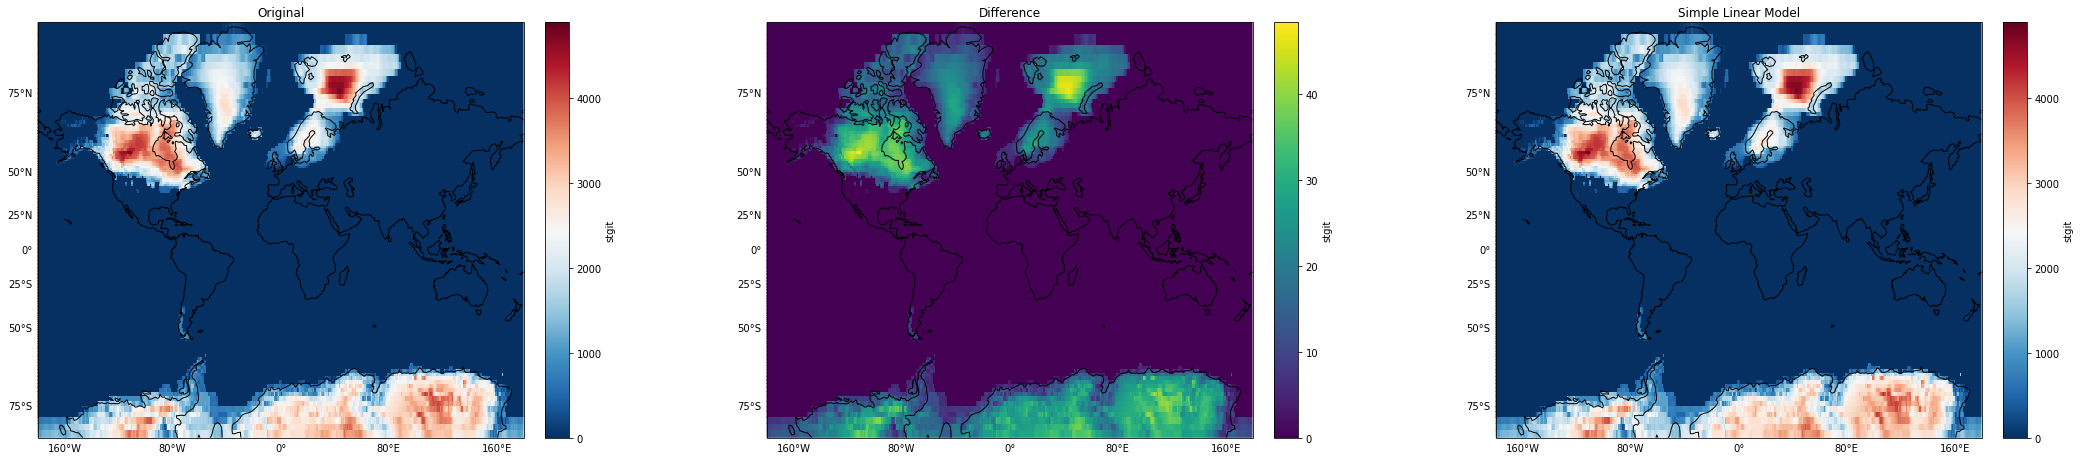

In [56]:
plot_ice_comparison_alt(ICE6G_D_122Ka, Linear_Test, 26.0, 'Simple Linear Model')

#### Latitude-Dependent Linear Model

:Layout
   .Overlay.I   :Overlay
      .Image.I     :Image   [Lon,Lat]   (stgit)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.II  :Overlay
      .Image.I     :Image   [Lon,Lat]   (stgit)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.III :Overlay
      .Image.I     :Image   [Lon,Lat]   (stgit)
      .Coastline.I :Feature   [Longitude,Latitude]
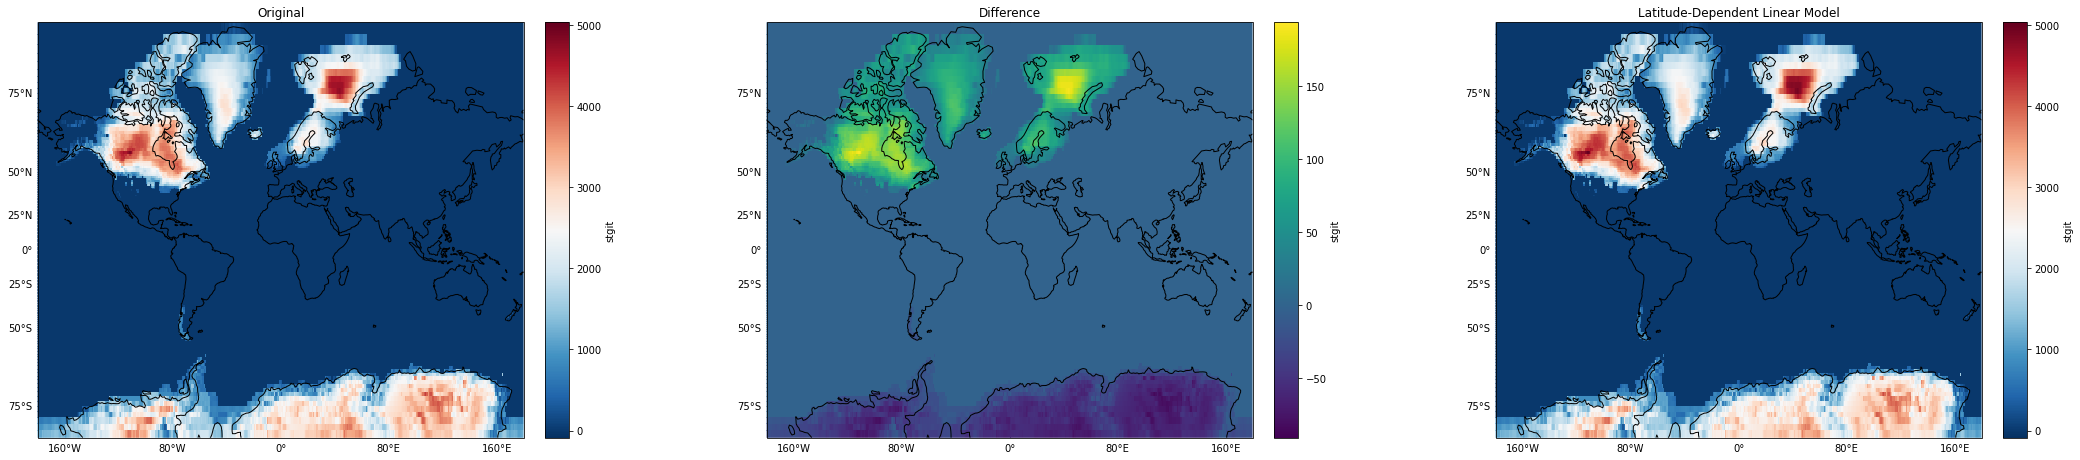

In [57]:
plot_ice_comparison_alt(ICE6G_D_122Ka, Linear_Lat_Test, 26.0, 'Latitude-Dependent Linear Model')

#### Quadratic Model

:Layout
   .Overlay.I   :Overlay
      .Image.I     :Image   [Lon,Lat]   (stgit)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.II  :Overlay
      .Image.I     :Image   [Lon,Lat]   (stgit)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.III :Overlay
      .Image.I     :Image   [Lon,Lat]   (stgit)
      .Coastline.I :Feature   [Longitude,Latitude]
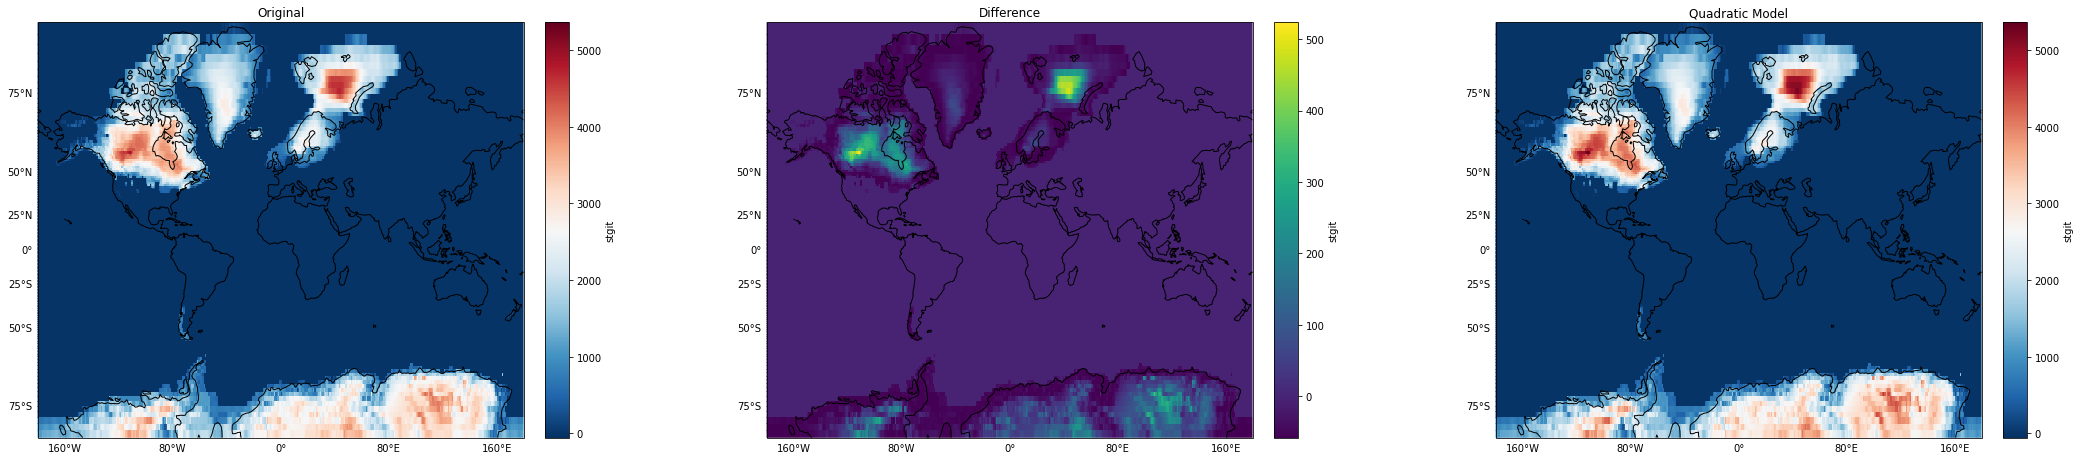

In [58]:
plot_ice_comparison_alt(ICE6G_D_122Ka, Quadratic_Test, 26.0, 'Quadratic Model')

#### Latitude-Dependent Quadratic Model

:Layout
   .Overlay.I   :Overlay
      .Image.I     :Image   [Lon,Lat]   (stgit)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.II  :Overlay
      .Image.I     :Image   [Lon,Lat]   (stgit)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.III :Overlay
      .Image.I     :Image   [Lon,Lat]   (stgit)
      .Coastline.I :Feature   [Longitude,Latitude]
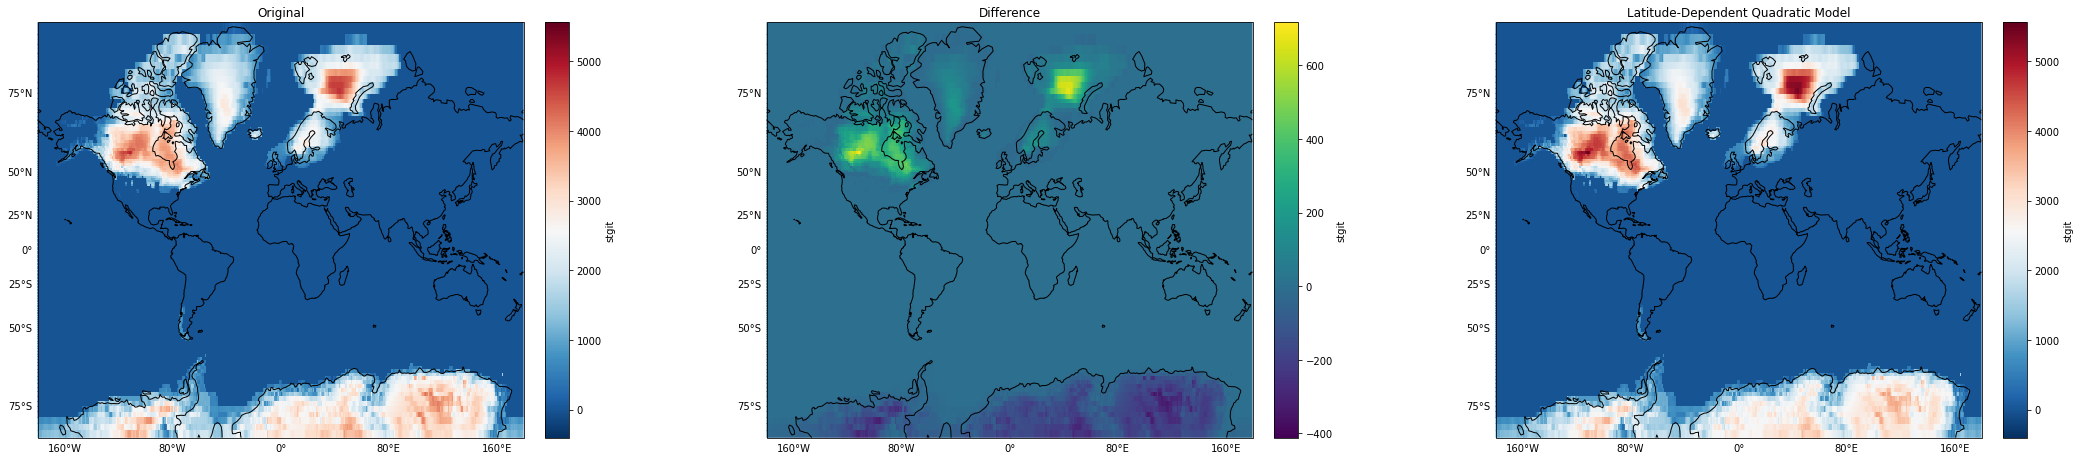

In [55]:
plot_ice_comparison_alt(ICE6G_D_122Ka, Quadratic_Lat_Test, 26.0, 'Latitude-Dependent Quadratic Model')